In [17]:
# Datetime
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno


# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline

import os

import random

import gzip, pickle, pickletools

import warnings
from pathlib import Path, PureWindowsPath
# ignore warnings
warnings.filterwarnings('ignore')

### Using the updated pickle files to model

In [18]:
#path_to_pickle = '/Users/williamearley/Documents/GitHub/Store-Sales/data/processed/'
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_to_pickle = path_cwd / 'data'
path_to_pickle

WindowsPath('C:/Users/Cornelius/Cory Dropbox/Cory LeRoy/PC/Documents/GitHub/Store-Sales/data')

In [19]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd
path = path_cwd / 'data/processed'

In [20]:
import gzip, pickle, pickletools

# create compressed pickle
filepath = path / 'df_train.pkl'
with gzip.open(filepath, 'rb') as f:
    p = pickle.Unpickler(f)
    df_train = p.load()
    
#df_train = pd.read_pickle(path_to_pickle / 'processed/df_train.pkl')
df_test = pd.read_pickle(path_to_pickle / 'processed/df_test.pkl')
df_val = pd.read_pickle(path_to_pickle / 'processed/df_val.pkl')

### Need to do some feature engineering first in order to take advantage of key aspects of the XGBoost algorithm.

On this train set we will implement dummy variables for the families

In [21]:
# One-hot encoding for family column
df_family_dummies_train = pd.get_dummies(df_train['family'], drop_first=True, prefix='family')
df_family_dummies_test = pd.get_dummies(df_test['family'], drop_first=True, prefix='family')
df_family_dummies_val = pd.get_dummies(df_val['family'], drop_first=True, prefix='family')

In [22]:
# One-hot encoding for family column, bringing dataframes together
df_train = pd.concat([df_train, df_family_dummies_train], axis=1)
df_test = pd.concat([df_test, df_family_dummies_test], axis=1)
df_val = pd.concat([df_val, df_family_dummies_val], axis=1)

In [23]:
# Replace False with 0.0 and True with 1.0
df_train.replace({False: 0.0, True: 1.0}, inplace=True)
df_test.replace({False: 0.0, True: 1.0}, inplace=True)
df_val.replace({False: 0.0, True: 1.0}, inplace=True)

In [24]:
# No longer need the original 'family' column
df_train = df_train.drop(columns=['family'])
df_test = df_test.drop(columns=['family'])
df_val = df_val.drop(columns=['family'])

In [25]:
# Set up training set
X_train = df_train.drop(columns=['sales', 'date'])
y_train = df_train['sales']

# Val set
X_val = df_val.drop(columns=['sales', 'date'])
y_val = df_val['sales']

# Test set
X_test = df_test.drop(columns=['sales', 'date'])
y_test = df_test['sales']

In [26]:
# Get the columns in the same order as X_train
columns_order = X_train.columns

# Reorder the columns in X_test and X_val
X_test = X_test[columns_order]
X_val = X_val[columns_order]

### Modeling

In [27]:
# Updated plot_predictions to work with dataframes where the date is not already aggregated
# This simply aggregates the dates inside the function
def plot_predictions(date, y_test, y_pred, forecast_label, title):
    """
    Plot the actual and predicted time series data.

    Parameters:
    date (array-like): Date or time index.
    y_test (array-like): Actual values.
    y_pred (array-like): Predicted values.
    forecast_label (str): Label for the forecasted data.
    title (str): Title for the plot.
    """
    # Combine the data into a DataFrame
    data = pd.DataFrame({'Date': date, 'Actual': y_test, 'Predicted': y_pred})
    
    # Aggregate the data by date, taking the mean of the values for each day
    data = data.groupby('Date').mean().reset_index()
    
    # Set the custom color palette
    custom_palette = sns.color_palette("husl", 2)
    sns.set_palette(custom_palette)
    
    # Create a figure with specified dimensions
    plt.figure(figsize=(10, 6))

    # Plot the actual data in green
    sns.lineplot(data=data, x='Date', y='Actual', label='Actual', color=custom_palette[0])

    # Plot the predicted data in blue with the specified label
    sns.lineplot(data=data, x='Date', y='Predicted', label=forecast_label, color=custom_palette[1])

    # Add a legend to the plot
    plt.legend()

    # Set the title of the plot
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()

In [28]:
# Define a function to compute the evaluations metrics after the forecast
def evaluate_forecast(y_test, forecast):
    """
    Compute MSE, RMSE, and RMSLE for a forecast.

    Parameters:
    y_test (array-like): Actual values.
    forecast (array-like): Predicted values.

    Returns:
    dict: Dictionary containing MSE, RMSE, and RMSLE.
    """
    def rmsle(predicted, actual):
        return np.sqrt(np.mean(np.square(np.log1p(predicted) - np.log1p(actual))))

    # Compute Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, forecast)
    
    # Compute Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Compute Root Mean Squared Logarithmic Error (RMSLE)
    rmsle_value = rmsle(forecast, y_test)
    
    # Return the evaluation metrics as a dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'RMSLE': rmsle_value
    }
    
    return metrics

## XGBOOST Regressor Model

In [29]:
# Define xgboost
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Fit model
model_xgb.fit(X_train, y_train)

# Predict
forecast_xgb = model_xgb.predict(X_test)

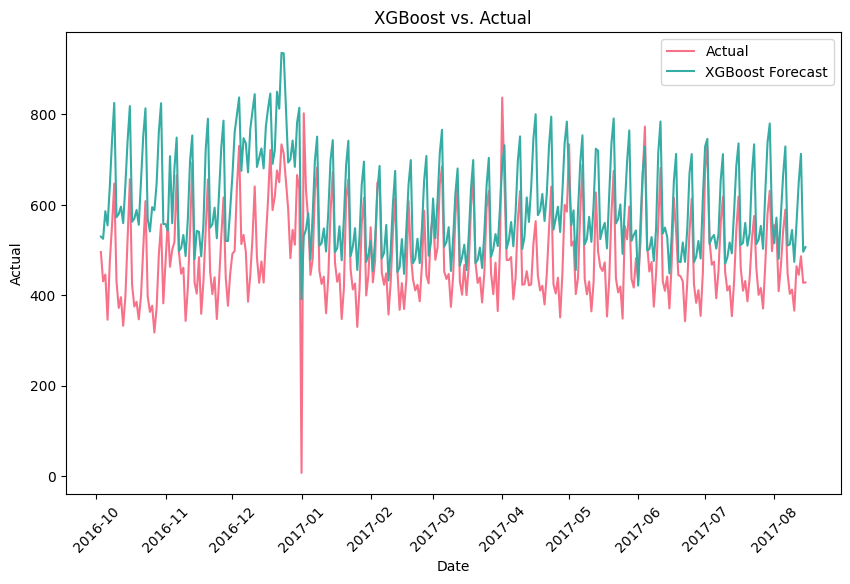

In [30]:
# Plot predictions
plot_predictions(df_test['date'], y_test, forecast_xgb, 'XGBoost Forecast', 'XGBoost vs. Actual')

In [31]:
# Metrics 
xgboost_metrics = evaluate_forecast(y_test, forecast_xgb)

xgboost_metrics

{'MSE': 497038.6890617026,
 'RMSE': 705.0097084875516,
 'RMSLE': 1.448618091866696}

## Hyperparameter Tuning

Going to be implementing a randomized search to fine-tune our XGBoost model. 

In [32]:
xgb_param_dist = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 400],
    'max_depth': [4, 6, 8]
}

# Instance of model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Perform search
random_search = RandomizedSearchCV(
    model_xgb,
    param_distributions = xgb_param_dist,
    n_iter=10,
    cv=10,
    scoring='neg_mean_squared_error',
    random_state=42
)

# Fit the model
random_search.fit(X_val, y_val)

# Get the best params
best_xgb_params = random_search.best_params_

# Print out
print("Best XGBoost parameters:", best_xgb_params)

# Get best estimator
best_xgb_model = random_search.best_estimator_

# Print out
best_xgb_model

Best XGBoost parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
# Make a prediction with the best model
forecast_xgb_best = best_xgb_model.predict(X_test)

In [34]:
# Calculate evaluation metrics
xgb_best = evaluate_forecast(y_test, forecast_xgb_best)

xgb_best

{'MSE': 182870.9580697888,
 'RMSE': 427.63414043991946,
 'RMSLE': 1.2597801741148478}

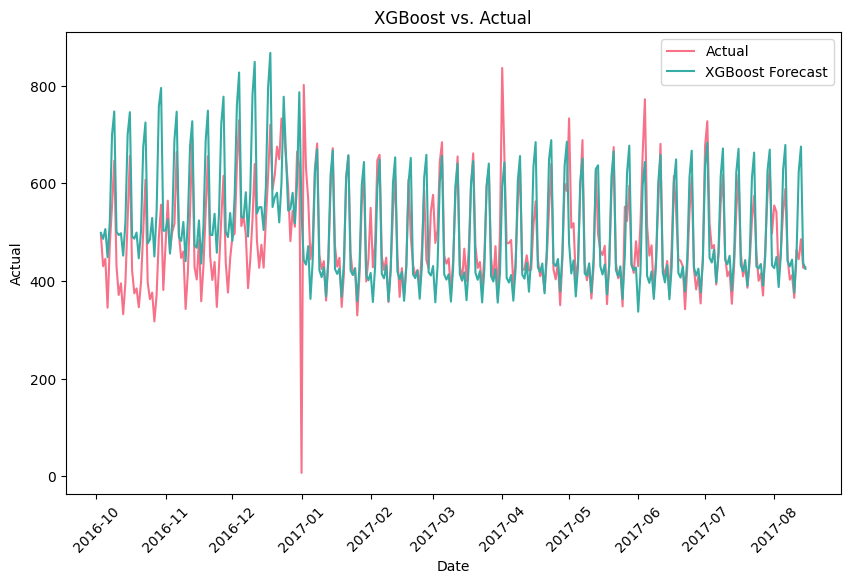

In [35]:
# Plot predictions
plot_predictions(df_test['date'], y_test, forecast_xgb_best, 'XGBoost Forecast', 'XGBoost vs. Actual')